# Imports

In [1]:
import numpy as np

import cycler
from matplotlib import pyplot as plt

import pygam
from sklearn.linear_model import RidgeCV
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from LookaheadCQR.lookahead.models.lookahead import Lookahead
import LookaheadCQR.lookahead.models.uncertainty as uncert
import LookaheadCQR.lookahead.models.prediction as pred
import LookaheadCQR.lookahead.models.propensity as prop
from LookaheadCQR.lookahead.models.models import polyRegression
from LookaheadCQR.cqr_lookahead.uncertainty import CQR

%matplotlib inline
np.set_printoptions(precision=3)

## Loading the diabetes dataset

In [2]:
#load data
data_bunch = load_diabetes()
x,y0 = data = load_diabetes(return_X_y=True)
y0 = -y0
y0 = (y0-np.min(y0))/(np.max(y0)-np.min(y0))
scaler = StandardScaler()
scaler.fit(x)
scaler.transform(x, copy=False)
n = x.shape[0]
d = x.shape[1]

## Defining the groundtruth model.
Here we choose linearGAM model as f*

In [3]:
# lams = np.random.rand(100, 13)
lams = np.random.rand(100, x.shape[1])
lams = lams * 6 - 3
lams = np.exp(lams)
fstar = pygam.LinearGAM(n_splines=12, max_iter=100).gridsearch(x, y0, lam=lams)
y = fstar.predict(x)
mse_star = np.mean(np.square(y-y0))
mae_star = np.mean(np.abs(y-y0))
print("[f*] mse(y,y0):", mse_star)
print("[f*] mae(y,y0):", mae_star)

100% (100 of 100) |######################| Elapsed Time: 0:05:56 Time:  0:05:56


[f*] mse(y,y0): 0.0245935075952418
[f*] mae(y,y0): 0.12569012838136162


<Figure size 432x288 with 0 Axes>

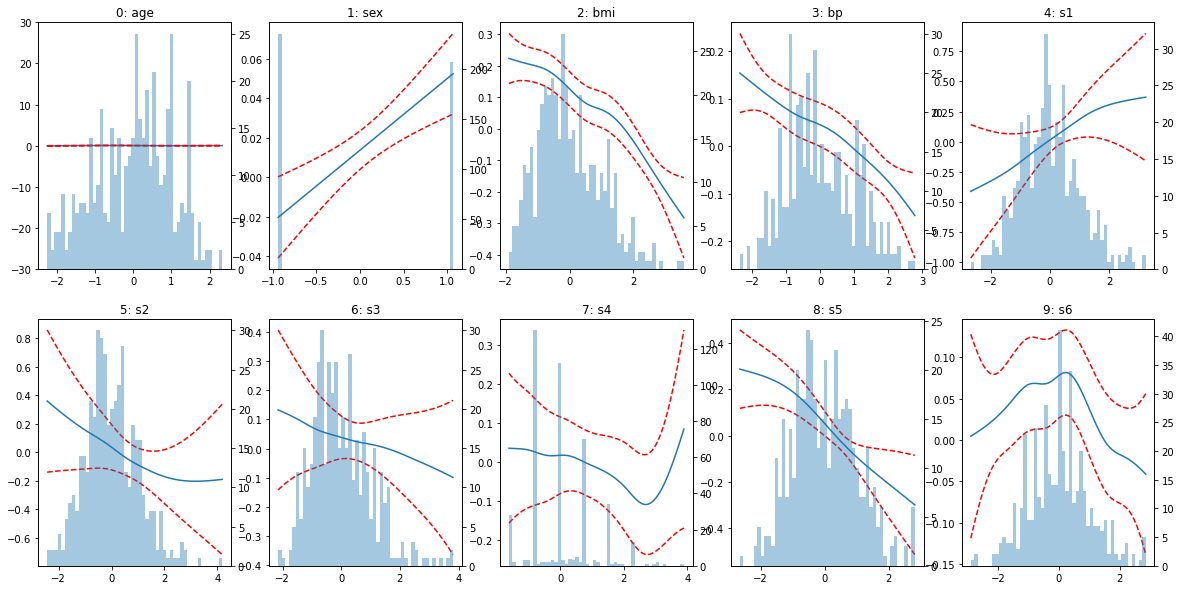

In [4]:
titles = data_bunch.feature_names
titles_idx = [str(i)+': '+titles[i] for i in range(len(titles))]
plt.figure()
fig, axs = plt.subplots(2,5,figsize=(20, 10))
for i, ax in enumerate(axs.flatten()[:x.shape[1]]):
    XX = fstar.generate_X_grid(term=i)
    ax.plot(XX[:, i], fstar.partial_dependence(term=i, X=XX))
    ax2 = ax.twinx()
    ax2.hist(x[:, i], alpha=.4, bins=50) #, density=True)
    ax.plot(XX[:, i], fstar.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles_idx[i])
plt.show()

## Generating the train-test splits

In [5]:
# split data
seed = 1
trn_sz = 0.75 # working-set relative size
active = np.arange(n) # No sub-sampling

x_active = x[active,:]
# y_active = y[active]
y_active = y0[active]
n_active = y_active.shape[0]

x_trn, x_tst, y_trn, y_tst, idx_trn, idx_tst = train_test_split(x_active, y_active, active, test_size=1-trn_sz, random_state=seed)
n_trn, n_tst = (x_trn.shape[0], x_tst.shape[0])
print('n:', n, ', n_active:', n_active, ", n_trn:", n_trn, ", n_tst:", n_tst)

xs = [x_trn, x_tst, x_active, x]
ys = [y_trn, y_tst, y_active, y]

n: 442 , n_active: 442 , n_trn: 331 , n_tst: 111


## Setting the hyperparamters of the look ahead model

In [6]:
# Step Size
eta = 5.

# L2 regularization coefficients
alphas = np.hstack([1e-5, 2.**np.arange(-8,6,1)])
alphas_sub = [0, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]

# Lookahead regularization coefficient
lams = np.hstack([1e-5, 2.**np.arange(-4,2,1)]) #lookahead penalty coefficients

# Setting features that can by altered using mask
# Features - 2 and 4 are the only non-immutable features
mask = np.zeros(d)
mask[[2,4]] = 1

# Degree of the polynomial to be used for regression
deg = 2

# Number of cycles to train
num_cycles = 10

# Confidence Intervals
z_score = 1.65 # for confiednce intervals (1.28-90%, 1.65=95%)

""" Hyperparameters for Prediction Model"""
# L2 - regularization coeffs
alpha_f = 0.5
# Regularization type (L1/L2)
reg_type = 'l2'
# Learning rate
lr_f = 0.05
# Number of iterations
num_iter_init = 1000 #for initial f
num_iter_f = 100 #for training f in cycles
num_iter_base = num_iter_init + num_iter_f*num_cycles

""" Hyperparameters for Uncertainty Model"""
# Number of bootstrapped models
num_gs = 20
# Learning rate
lr_g = 0.05
# Number of iterations
num_iter_g = 500 #for training g in cycles

## Training a baseline model and displaying the weights learnt and the result

In [7]:
# baselines
verbose = True

# scikitlearn - to get optimal regularization coefficient via CV)
f_base_skl = RidgeCV(alphas=alphas, cv=None).fit(x_trn, y_trn)
w_base_skl = f_base_skl.coef_
best_alpha = float(f_base_skl.alpha_)
best_alpha_idx = int(np.where(alphas==best_alpha)[0])

# benchmark trained on all data
f_bench = RidgeCV(alphas=alphas, cv=None).fit(x, y)
w_bench = f_bench.coef_

# ours - for sanity check (vs SKL) and to get baseline improvement
f_base = pred.PredModel(d, reg_type=reg_type, alpha=best_alpha, lr=lr_f, num_iter_init=num_iter_base, model=polyRegression(d,1,deg))
model_base = Lookahead(f_base, None, None, lam=0., eta=eta, mask=mask, ground_truth_model=fstar)
_, _ = model_base.train(x_trn, y_trn, num_cycles=0, random_state=seed, verbose=verbose)

t: 0
[f] mse: 0.0265, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0280
[f] improve*: 0.030



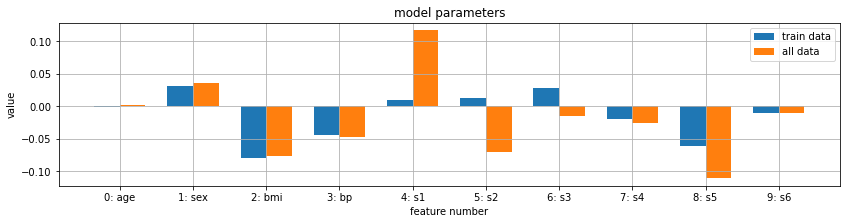

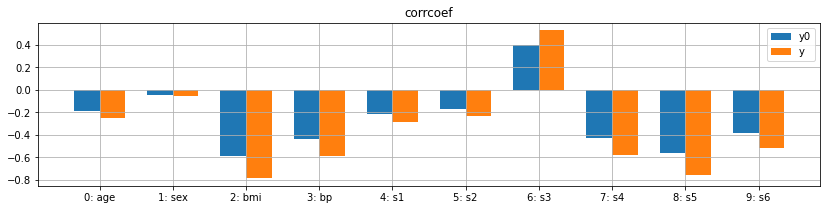

baseline: (skl)
		trn	tst	actv	all
mse	0.0279	0.0285	0.0281	0.0023
mae	0.1375	0.1317	0.1361	0.0368

baseline: (ours)
base:	trn	tst	actv	all
mse	0.0265	0.0286	0.0270	0.0013
mae	0.1336	0.1302	0.1327	0.0281
imprv	0.0301	0.0442	0.0336	0.0336
imprt	0.5589	0.6036	0.5701	0.9774

best reg coef: 32.0 , idx: 14


In [8]:
plt.rcParams['figure.figsize'] = (14.0, 3.0)
barWidth = 0.35
plt.bar(np.arange(d)-barWidth/2,w_base_skl,alpha=1,width=barWidth)
plt.bar(np.arange(d)+barWidth/2,w_bench,alpha=1,width=barWidth)
# plt.bar(np.arange(d)-barWidth/2,w_base_skl/np.sum(np.abs(w_base_skl)),alpha=0.6,width=barWidth)
# plt.bar(np.arange(d)+barWidth/2,w_bench/np.sum(np.abs(w_bench)),alpha=0.6,width=barWidth)
plt.xticks(np.arange(d),titles_idx)
plt.title('model parameters')
plt.ylabel('value')
plt.xlabel('feature number')
plt.legend(['train data','all data'])
plt.grid()
plt.show()


cor_y0 = [np.corrcoef(x[:,i],y0)[0,1] for i in range(d)]
cor_y = [np.corrcoef(x[:,i],y)[0,1] for i in range(d)]
plt.bar(np.arange(d)-barWidth/2,cor_y0,width=barWidth)
plt.bar(np.arange(d)+barWidth/2,cor_y,width=barWidth)
plt.title('corrcoef')
plt.legend(['y0','y'])
plt.xticks(np.arange(d),titles_idx)
plt.grid()
plt.show()

perf_base_skl = {'mse':[], 'mae':[]}
for x_,y_ in zip(xs, ys):
    yhat_ = f_base_skl.predict(x_)
    perf_base_skl['mse'].append(np.mean(np.square(y_-yhat_)))
    perf_base_skl['mae'].append(np.mean(np.abs(y_-yhat_)))
print('baseline: (skl)')
print('\t\ttrn\ttst\tactv\tall')
print(('mse'+'\t{:.4f}'*4).format(*perf_base_skl['mse']))
print(('mae'+'\t{:.4f}'*4).format(*perf_base_skl['mae']))
print()

perf_base = {'mse':[], 'mae':[], 'improve':[], 'imprate':[]}
for x_,y_ in zip(xs, ys):
    perf_base['mse'].append(model_base.mse(x_,y_))
    perf_base['mae'].append(model_base.mae(x_,y_))
    perf_base['improve'].append(model_base.improve(x_,y_,eta,mask))
    perf_base['imprate'].append(model_base.improve_rate(x_,y_,eta,mask))
print('baseline: (ours)')
print('base:\ttrn\ttst\tactv\tall')
print(('mse'+'\t{:.4f}'*4).format(*perf_base['mse']))
print(('mae'+'\t{:.4f}'*4).format(*perf_base['mae']))
print(('imprv'+'\t{:.4f}'*4).format(*perf_base['improve']))
print(('imprt'+'\t{:.4f}'*4).format(*perf_base['imprate']))
print()

print('best reg coef:', best_alpha, ', idx:', best_alpha_idx)

## Train a baseline model on different values of l2 regularizer and naive model for different scales

In [9]:
# train:
#  - baseline model on all alphas
#  - naive model on multiple step size svcales

alphas = np.hstack([1e-5, 2.**np.arange(-8,6,3)]) #l2 penalty coefficients

verbose = True

models_base = []
for alpha in alphas:
    f_base = pred.PredModel(d, reg_type=reg_type, alpha=alpha, lr=lr_f, num_iter_init=num_iter_base, model=polyRegression(d,1,deg))
    model_base = Lookahead(f_base, None, None, lam=0., eta=eta, mask=mask, ground_truth_model=fstar)
    _, _ = model_base.train(x_trn, y_trn, num_cycles=0, random_state=seed, verbose=verbose)
    models_base.append(model_base)

perf_base = {'mse':[], 'mae':[], 'improve':[], 'imprate':[]} #, 'contain':[], 'size':[]}
for model in models_base:
    perf_base['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_base['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_base['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
    perf_base['imprate'].append([model.improve_rate(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
perf_base = {k:np.asarray(v) for k,v in zip(perf_base.keys(),perf_base.values())}

t: 0
[f] mse: 0.0260, la_reg: 0.0000, norm_reg: 0.0003, obj: 0.0260
[f] improve*: 0.089

t: 0
[f] mse: 0.0260, la_reg: 0.0000, norm_reg: 0.0003, obj: 0.0260
[f] improve*: 0.089

t: 0
[f] mse: 0.0260, la_reg: 0.0000, norm_reg: 0.0003, obj: 0.0260
[f] improve*: 0.089

t: 0
[f] mse: 0.0260, la_reg: 0.0000, norm_reg: 0.0003, obj: 0.0261
[f] improve*: 0.086

t: 0
[f] mse: 0.0261, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0263
[f] improve*: 0.069

t: 0
[f] mse: 0.0263, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0272
[f] improve*: 0.037



In [10]:
for i in range(len(alphas)):
    print('\n==============================================\n')
    print('alpha:', alphas[i])
    print('\ttrn\ttst\tactv\tall\tf*')
    print(('mse'+'\t{:.4f}'*5).format(*perf_base['mse'][i,:], mse_star))
    print(('mae'+'\t{:.4f}'*5).format(*perf_base['mae'][i,:], mae_star))
    print(('imprv'+'\t{:.4f}'*4).format(*perf_base['improve'][i,:]))
    print(('imprt'+'\t{:.4f}'*4).format(*perf_base['imprate'][i,:]))
    print()



alpha: 1e-05
	trn	tst	actv	all	f*
mse	0.0260	0.0299	0.0270	0.0014	0.0246
mae	0.1320	0.1313	0.1318	0.0278	0.1257
imprv	0.0891	0.1054	0.0932	0.0932
imprt	0.7100	0.7477	0.7195	0.9955



alpha: 0.00390625
	trn	tst	actv	all	f*
mse	0.0260	0.0299	0.0270	0.0014	0.0246
mae	0.1320	0.1313	0.1318	0.0278	0.1257
imprv	0.0890	0.1053	0.0931	0.0931
imprt	0.7100	0.7477	0.7195	0.9955



alpha: 0.03125
	trn	tst	actv	all	f*
mse	0.0260	0.0299	0.0270	0.0014	0.0246
mae	0.1320	0.1313	0.1318	0.0278	0.1257
imprv	0.0887	0.1049	0.0927	0.0927
imprt	0.7100	0.7477	0.7195	0.9955



alpha: 0.25
	trn	tst	actv	all	f*
mse	0.0260	0.0299	0.0270	0.0014	0.0246
mae	0.1320	0.1313	0.1318	0.0278	0.1257
imprv	0.0858	0.1020	0.0899	0.0899
imprt	0.7069	0.7477	0.7172	0.9955



alpha: 2.0
	trn	tst	actv	all	f*
mse	0.0261	0.0297	0.0270	0.0013	0.0246
mae	0.1321	0.1312	0.1319	0.0276	0.1257
imprv	0.0689	0.0846	0.0729	0.0729
imprt	0.6405	0.7027	0.6561	0.9819



alpha: 16.0
	trn	tst	actv	all	f*
mse	0.0263	0.0290	0.0269	0.0012	0.0246
mae	0.1

## Training the lookahead model for different values of l2-regularizer coefficients

In [11]:
# train our model
verbose = True

#==TEMP==
alphas_sub = [0, 0.1, 2, 4.0]
lams = [0, 0.01, 0.05]
num_cycles = 10
#========

all_models = []
all_mfs = []
all_mus = []
for alpha in alphas_sub:
    models = []
    mfs = []
    mus = []
    for lam_ in lams:
        print('-- alpha:', alpha, ', lam_:', lam_, '--')
        f = pred.PredModel(d, reg_type=reg_type, alpha=alpha, lr=lr_f, num_iter=num_iter_f, num_iter_init=num_iter_init, model=polyRegression(d,1,deg))
        u = uncert.QuantReg(d, tau=[0.1,0.9], alpha=0., lr=lr_g, num_iter=num_iter_g, model=polyRegression(d,1,deg))
        h = prop.PropModel(random_state=seed)

        model = Lookahead(f, u, h, lam=lam_, eta=eta, mask=mask, ground_truth_model=fstar)
        mf, mu = model.train(x_trn, y_trn, num_cycles=num_cycles, random_state=seed, verbose=verbose)

        models.append(model)
        mfs.append(mf)
        mus.append(mu)
    all_models.append(models)
    all_mfs.append(mfs)
    all_mus.append(mus)


all_mus = np.asarray(all_mus)
all_mfs = np.asarray(all_mfs)

-- alpha: 0 , lam_: 0 --
t: 0
[f] mse: 0.0261, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0261
[f] improve*: 0.053

t: 1
[h] n_eff: 75.44, w_sum: 356.60
[u] loss: 0.0539, norm_reg: 0.0000, obj: 0.0539
[u] size: 0.413, contain*: 0.958
[f] mse: 0.0261, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0261
[f] improve*: 0.056

t: 2
[h] n_eff: 51.27, w_sum: 371.96
[u] loss: 0.0562, norm_reg: 0.0000, obj: 0.0562
[u] size: 0.437, contain*: 0.994
[f] mse: 0.0261, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0261
[f] improve*: 0.060

t: 3
[h] n_eff: 35.59, w_sum: 390.27
[u] loss: 0.0492, norm_reg: 0.0000, obj: 0.0492
[u] size: 0.378, contain*: 0.918
[f] mse: 0.0261, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0261
[f] improve*: 0.064

t: 4
[h] n_eff: 25.70, w_sum: 410.34
[u] loss: 0.0620, norm_reg: 0.0000, obj: 0.0620
[u] size: 0.372, contain*: 0.909
[f] mse: 0.0261, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0261
[f] improve*: 0.068

t: 5
[h] n_eff: 19.43, w_sum: 430.37
[u] loss: 0.0502, norm_reg: 0.0000, obj: 

[f] mse: 0.0260, la_reg: 0.0000, norm_reg: 0.0003, obj: 0.0261
[f] improve*: 0.084

t: 10
[h] n_eff: 8.96, w_sum: 466.82
[u] loss: 0.0848, norm_reg: 0.0000, obj: 0.0848
[u] size: 0.613, contain*: 0.979
[f] mse: 0.0260, la_reg: 0.0000, norm_reg: 0.0003, obj: 0.0261
[f] improve*: 0.088

-- alpha: 0.1 , lam_: 0.01 --
t: 0
[f] mse: 0.0261, la_reg: 0.0000, norm_reg: 0.0003, obj: 0.0261
[f] improve*: 0.053

t: 1
[h] n_eff: 75.67, w_sum: 356.49
[u] loss: 0.0541, norm_reg: 0.0000, obj: 0.0541
[u] size: 0.457, contain*: 0.997
[f] mse: 0.0261, la_reg: 0.1644, norm_reg: 0.0003, obj: 0.0278
[f] improve*: 0.069

t: 2
[h] n_eff: 23.58, w_sum: 411.06
[u] loss: 0.0615, norm_reg: 0.0000, obj: 0.0615
[u] size: 0.516, contain*: 0.991
[f] mse: 0.0261, la_reg: 0.1749, norm_reg: 0.0003, obj: 0.0279
[f] improve*: 0.082

t: 3
[h] n_eff: 14.38, w_sum: 431.43
[u] loss: 0.0579, norm_reg: 0.0000, obj: 0.0579
[u] size: 0.473, contain*: 0.927
[f] mse: 0.0261, la_reg: 0.1966, norm_reg: 0.0003, obj: 0.0281
[f] improv

[h] n_eff: 12.32, w_sum: 402.67
[u] loss: 0.0552, norm_reg: 0.0000, obj: 0.0552
[u] size: 0.517, contain*: 0.976
[f] mse: 0.0261, la_reg: 0.2383, norm_reg: 0.0002, obj: 0.0288
[f] improve*: 0.099

t: 9
[h] n_eff: 11.25, w_sum: 386.54
[u] loss: 0.0587, norm_reg: 0.0000, obj: 0.0587
[u] size: 0.485, contain*: 0.946
[f] mse: 0.0260, la_reg: 0.2353, norm_reg: 0.0002, obj: 0.0287
[f] improve*: 0.101

t: 10
[h] n_eff: 10.89, w_sum: 371.80
[u] loss: 0.0947, norm_reg: 0.0000, obj: 0.0947
[u] size: 0.672, contain*: 0.958
[f] mse: 0.0260, la_reg: 0.2942, norm_reg: 0.0002, obj: 0.0293
[f] improve*: 0.105

-- alpha: 2 , lam_: 0.05 --
t: 0
[f] mse: 0.0261, la_reg: 0.0000, norm_reg: 0.0002, obj: 0.0264
[f] improve*: 0.050

t: 1
[h] n_eff: 82.31, w_sum: 353.50
[u] loss: 0.0463, norm_reg: 0.0000, obj: 0.0463
[u] size: 0.414, contain*: 0.982
[f] mse: 0.0263, la_reg: 0.1323, norm_reg: 0.0002, obj: 0.0333
[f] improve*: 0.101

t: 2
[h] n_eff: 7.89, w_sum: 405.42
[u] loss: 0.0708, norm_reg: 0.0000, obj: 0.

[h] n_eff: 17.41, w_sum: 287.08
[u] loss: 0.0572, norm_reg: 0.0000, obj: 0.0572
[u] size: 0.486, contain*: 0.843
[f] mse: 0.0266, la_reg: 0.1589, norm_reg: 0.0002, obj: 0.0353
[f] improve*: 0.135

t: 8
[h] n_eff: 18.25, w_sum: 271.99
[u] loss: 0.0597, norm_reg: 0.0000, obj: 0.0597
[u] size: 0.499, contain*: 0.852
[f] mse: 0.0267, la_reg: 0.1671, norm_reg: 0.0002, obj: 0.0359
[f] improve*: 0.132

t: 9
[h] n_eff: 20.00, w_sum: 291.24
[u] loss: 0.0424, norm_reg: 0.0000, obj: 0.0424
[u] size: 0.443, contain*: 0.894
[f] mse: 0.0268, la_reg: 0.1717, norm_reg: 0.0002, obj: 0.0362
[f] improve*: 0.127

t: 10
[h] n_eff: 24.21, w_sum: 313.66
[u] loss: 0.0514, norm_reg: 0.0000, obj: 0.0514
[u] size: 0.474, contain*: 0.921
[f] mse: 0.0267, la_reg: 0.1819, norm_reg: 0.0002, obj: 0.0366
[f] improve*: 0.131



## Evaluating the performance of the trained lookahead models

In [12]:
# evaluate

all_perf_la = []
for i in range(len(alphas_sub)):
    perf_la = {'mse':[], 'mae':[], 'improve':[], 'imprate':[], 'contain':[], 'size':[]}
    for lam, model in zip(lams,all_models[i]):
        perf_la['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
        perf_la['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
        perf_la['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
        perf_la['imprate'].append([model.improve_rate(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])

        xsp = [model.move_points(x_) for x_ in xs]
        perf_la['contain'].append([model.contain(x_)[0] for x_ in [*xsp, x]])
        perf_la['size'].append([model.contain(x_)[1] for x_ in [*xsp, x]])
    perf_la = {k:np.asarray(v) for k,v in zip(perf_la.keys(),perf_la.values())}
    all_perf_la.append(perf_la)

print('lookahead: eta:', eta)
for j in range(len(alphas_sub)):
    for i in range(len(lams)):
        print('\n==============================================\n')
        print('alpha:', alphas_sub[j], 'lam:', lams[i])
        print('\ttrn\ttst\tactv\tall\tf*')
        print(('mse'+'\t{:.4f}'*5).format(*all_perf_la[j]['mse'][i,:], mse_star))
        print(('mae'+'\t{:.4f}'*5).format(*all_perf_la[j]['mae'][i,:], mae_star))
        print(('imprv'+'\t{:.4f}'*4).format(*all_perf_la[j]['improve'][i,:]))
        print(('imprt'+'\t{:.4f}'*4).format(*all_perf_la[j]['imprate'][i,:]))
        print()
        print('\ttrn\'\ttst\'\tactv\'\tall\'\tall')
        print(('contn'+'\t{:.3f}'*5).format(*all_perf_la[j]['contain'][i,:]))
        print(('intrsz'+'\t{:.3f}'*5).format(*all_perf_la[j]['size'][i,:]))

lookahead: eta: 5.0


alpha: 0 lam: 0
	trn	tst	actv	all	f*
mse	0.0260	0.0299	0.0270	0.0014	0.0246
mae	0.1320	0.1313	0.1318	0.0278	0.1257
imprv	0.0891	0.1054	0.0932	0.0932
imprt	0.7100	0.7477	0.7195	0.9955

	trn'	tst'	actv'	all'	all
contn	0.946	0.964	0.950	0.950	0.966
intrsz	0.514	0.501	0.511	0.511	0.560


alpha: 0 lam: 0.01
	trn	tst	actv	all	f*
mse	0.0260	0.0308	0.0272	0.0016	0.0246
mae	0.1321	0.1327	0.1322	0.0302	0.1257
imprv	0.1321	0.1498	0.1365	0.1365
imprt	0.7734	0.8198	0.7851	1.0000

	trn'	tst'	actv'	all'	all
contn	0.882	0.865	0.878	0.878	0.971
intrsz	0.449	0.439	0.446	0.446	0.561


alpha: 0 lam: 0.05
	trn	tst	actv	all	f*
mse	0.0269	0.0342	0.0287	0.0031	0.0246
mae	0.1342	0.1380	0.1352	0.0428	0.1257
imprv	0.1550	0.1746	0.1599	0.1599
imprt	0.7976	0.8378	0.8077	0.9706

	trn'	tst'	actv'	all'	all
contn	0.937	0.937	0.937	0.937	0.991
intrsz	0.544	0.535	0.542	0.542	0.632


alpha: 0.1 lam: 0
	trn	tst	actv	all	f*
mse	0.0260	0.0299	0.0270	0.0014	0.0246
mae	0.1320	0.1313	0.1318	0.0278	0.1257


## Training the lookahead+CQR model for different values of l2-regularizer coefficients

In [13]:
# train our model
verbose = True

all_cqr_models = []
all_cqr_mfs = []
all_cqr_mus = []
for alpha in alphas_sub:
    cqr_models = []
    cqr_mfs = []
    cqr_mus = []
    for lam_ in lams:
        print('-- alpha:', alpha, ', lam_:', lam_, '--')
        f = pred.PredModel(d, reg_type=reg_type, alpha=alpha, lr=lr_f, num_iter=num_iter_f, num_iter_init=num_iter_init, model=polyRegression(d,1,deg))
        u = CQR(d, tau=(0.1, 0.9), lr=0.001, num_iter=5000)
        h = prop.PropModel(random_state=seed)

        model = Lookahead(f, u, h, lam=lam_, eta=eta, mask=mask, ground_truth_model=fstar)
        mf, mu = model.train(x_trn, y_trn, num_cycles=num_cycles, random_state=seed, verbose=verbose)

        cqr_models.append(model)
        cqr_mfs.append(mf)
        cqr_mus.append(mu)

    all_cqr_models.append(cqr_models)
    all_cqr_mfs.append(cqr_mfs)
    all_cqr_mus.append(cqr_mus)


all_cqr_mus = np.asarray(all_cqr_mus)
all_cqr_mfs = np.asarray(all_cqr_mfs)

-- alpha: 0 , lam_: 0 --
t: 0
[f] mse: 0.0261, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0261
[f] improve*: 0.053

t: 1
[h] n_eff: 75.44, w_sum: 356.60
[u] loss: 0.0638, norm_reg: 0.0000, obj: 0.0638
[u] size: 0.749, contain*: 1.000
[f] mse: 0.0261, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0261
[f] improve*: 0.056

t: 2
[h] n_eff: 51.27, w_sum: 371.96
[u] loss: 0.0582, norm_reg: 0.0000, obj: 0.0582
[u] size: 0.644, contain*: 1.000
[f] mse: 0.0261, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0261
[f] improve*: 0.060

t: 3
[h] n_eff: 35.59, w_sum: 390.27
[u] loss: 0.0548, norm_reg: 0.0000, obj: 0.0548
[u] size: 0.600, contain*: 1.000
[f] mse: 0.0261, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0261
[f] improve*: 0.064

t: 4
[h] n_eff: 25.70, w_sum: 410.34
[u] loss: 0.0468, norm_reg: 0.0000, obj: 0.0468
[u] size: 0.600, contain*: 1.000
[f] mse: 0.0261, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0261
[f] improve*: 0.068

t: 5
[h] n_eff: 19.43, w_sum: 430.37
[u] loss: 0.0540, norm_reg: 0.0000, obj: 

[h] n_eff: 8.96, w_sum: 466.82
[u] loss: 0.0388, norm_reg: 0.0000, obj: 0.0388
[u] size: 0.700, contain*: 1.000
[f] mse: 0.0260, la_reg: 0.0000, norm_reg: 0.0003, obj: 0.0261
[f] improve*: 0.088

-- alpha: 0.1 , lam_: 0.01 --
t: 0
[f] mse: 0.0261, la_reg: 0.0000, norm_reg: 0.0003, obj: 0.0261
[f] improve*: 0.053

t: 1
[h] n_eff: 75.67, w_sum: 356.49
[u] loss: 0.0631, norm_reg: 0.0000, obj: 0.0631
[u] size: 0.692, contain*: 1.000
[f] mse: 0.0261, la_reg: 0.3167, norm_reg: 0.0003, obj: 0.0293
[f] improve*: 0.058

t: 2
[h] n_eff: 47.08, w_sum: 374.18
[u] loss: 0.0491, norm_reg: 0.0000, obj: 0.0491
[u] size: 0.712, contain*: 1.000
[f] mse: 0.0261, la_reg: 0.3241, norm_reg: 0.0003, obj: 0.0294
[f] improve*: 0.062

t: 3
[h] n_eff: 32.55, w_sum: 393.36
[u] loss: 0.0523, norm_reg: 0.0000, obj: 0.0523
[u] size: 0.615, contain*: 1.000
[f] mse: 0.0261, la_reg: 0.3011, norm_reg: 0.0003, obj: 0.0291
[f] improve*: 0.065

t: 4
[h] n_eff: 23.71, w_sum: 413.74
[u] loss: 0.0394, norm_reg: 0.0000, obj: 0

[f] mse: 0.0261, la_reg: 0.3196, norm_reg: 0.0001, obj: 0.0295
[f] improve*: 0.066

t: 9
[h] n_eff: 15.24, w_sum: 455.86
[u] loss: 0.0487, norm_reg: 0.0000, obj: 0.0487
[u] size: 0.664, contain*: 1.000
[f] mse: 0.0261, la_reg: 0.3267, norm_reg: 0.0001, obj: 0.0296
[f] improve*: 0.068

t: 10
[h] n_eff: 13.35, w_sum: 469.53
[u] loss: 0.0550, norm_reg: 0.0000, obj: 0.0550
[u] size: 0.628, contain*: 1.000
[f] mse: 0.0261, la_reg: 0.3150, norm_reg: 0.0001, obj: 0.0295
[f] improve*: 0.069

-- alpha: 2 , lam_: 0.05 --
t: 0
[f] mse: 0.0261, la_reg: 0.0000, norm_reg: 0.0002, obj: 0.0264
[f] improve*: 0.050

t: 1
[h] n_eff: 82.31, w_sum: 353.50
[u] loss: 0.0648, norm_reg: 0.0000, obj: 0.0648
[u] size: 0.723, contain*: 1.000
[f] mse: 0.0262, la_reg: 0.3485, norm_reg: 0.0002, obj: 0.0440
[f] improve*: 0.055

t: 2
[h] n_eff: 62.02, w_sum: 355.95
[u] loss: 0.0566, norm_reg: 0.0000, obj: 0.0566
[u] size: 0.658, contain*: 1.000
[f] mse: 0.0263, la_reg: 0.3108, norm_reg: 0.0001, obj: 0.0421
[f] improve

[h] n_eff: 222.11, w_sum: 322.62
[u] loss: 0.0575, norm_reg: 0.0000, obj: 0.0575
[u] size: 0.613, contain*: 0.997
[f] mse: 0.0263, la_reg: 0.2945, norm_reg: 0.0001, obj: 0.0414
[f] improve*: 0.037

t: 8
[h] n_eff: 237.78, w_sum: 321.40
[u] loss: 0.0452, norm_reg: 0.0000, obj: 0.0452
[u] size: 0.542, contain*: 0.994
[f] mse: 0.0263, la_reg: 0.2724, norm_reg: 0.0001, obj: 0.0403
[f] improve*: 0.036

t: 9
[h] n_eff: 244.56, w_sum: 320.47
[u] loss: 0.0425, norm_reg: 0.0000, obj: 0.0425
[u] size: 0.683, contain*: 1.000
[f] mse: 0.0264, la_reg: 0.3272, norm_reg: 0.0001, obj: 0.0431
[f] improve*: 0.036

t: 10
[h] n_eff: 242.68, w_sum: 319.91
[u] loss: 0.0393, norm_reg: 0.0000, obj: 0.0393
[u] size: 0.615, contain*: 0.997
[f] mse: 0.0263, la_reg: 0.2965, norm_reg: 0.0001, obj: 0.0415
[f] improve*: 0.033



## Evaluating the performance of the trained lookahead+CQR models

In [14]:
# evaluate
all_perf_cqr_la = []
for i in range(len(alphas_sub)):
    perf_cqr_la = {'mse':[], 'mae':[], 'improve':[], 'imprate':[], 'contain':[], 'size':[]}
    for lam, model in zip(lams,all_cqr_models[i]):
        perf_cqr_la['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
        perf_cqr_la['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
        perf_cqr_la['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
        perf_cqr_la['imprate'].append([model.improve_rate(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])

        xsp = [model.move_points(x_) for x_ in xs]
        perf_cqr_la['contain'].append([model.contain(x_)[0] for x_ in [*xsp, x]])
        perf_cqr_la['size'].append([model.contain(x_)[1] for x_ in [*xsp, x]])
    perf_cqr_la = {k:np.asarray(v) for k,v in zip(perf_cqr_la.keys(),perf_cqr_la.values())}
    all_perf_cqr_la.append(perf_cqr_la)

print('lookahead+CQR: eta:', eta)
for j in range(len(alphas_sub)):
    for i in range(len(lams)):
        print('\n==============================================\n')
        print('alpha:', alphas_sub[j], 'lam:', lams[i])
        print('\ttrn\ttst\tactv\tall\tf*')
        print(('mse'+'\t{:.4f}'*5).format(*all_perf_cqr_la[j]['mse'][i,:], mse_star))
        print(('mae'+'\t{:.4f}'*5).format(*all_perf_cqr_la[j]['mae'][i,:], mae_star))
        print(('imprv'+'\t{:.4f}'*4).format(*all_perf_cqr_la[j]['improve'][i,:]))
        print(('imprt'+'\t{:.4f}'*4).format(*all_perf_cqr_la[j]['imprate'][i,:]))
        print()
        print('\ttrn\'\ttst\'\tactv\'\tall\'\tall')
        print(('contn'+'\t{:.3f}'*5).format(*all_perf_cqr_la[j]['contain'][i,:]))
        print(('intrsz'+'\t{:.3f}'*5).format(*all_perf_cqr_la[j]['size'][i,:]))

lookahead+CQR: eta: 5.0


alpha: 0 lam: 0
	trn	tst	actv	all	f*
mse	0.0260	0.0299	0.0270	0.0014	0.0246
mae	0.1320	0.1313	0.1318	0.0278	0.1257
imprv	0.0891	0.1054	0.0932	0.0932
imprt	0.7100	0.7477	0.7195	0.9955

	trn'	tst'	actv'	all'	all
contn	1.000	1.000	1.000	1.000	1.000
intrsz	0.595	0.584	0.591	0.592	0.617


alpha: 0 lam: 0.01
	trn	tst	actv	all	f*
mse	0.0260	0.0301	0.0270	0.0014	0.0246
mae	0.1319	0.1318	0.1319	0.0283	0.1257
imprv	0.1014	0.1180	0.1056	0.1056
imprt	0.7190	0.7658	0.7308	1.0000

	trn'	tst'	actv'	all'	all
contn	0.997	1.000	0.998	1.000	1.000
intrsz	0.604	0.595	0.600	0.601	0.613


alpha: 0 lam: 0.05
	trn	tst	actv	all	f*
mse	0.0261	0.0311	0.0274	0.0018	0.0246
mae	0.1322	0.1342	0.1327	0.0323	0.1257
imprv	0.1540	0.1720	0.1585	0.1585
imprt	0.8187	0.8468	0.8258	1.0000

	trn'	tst'	actv'	all'	all
contn	1.000	1.000	1.000	1.000	1.000
intrsz	0.704	0.696	0.701	0.703	0.724


alpha: 0.1 lam: 0
	trn	tst	actv	all	f*
mse	0.0260	0.0299	0.0270	0.0014	0.0246
mae	0.1320	0.1313	0.1318	0.0278	0.1

## Plots Lookahead

<ipython-input-15-f332be23954e>:38: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='',xytext=(x_tst[i,feats[0]],x_tst[i,feats[1]]),


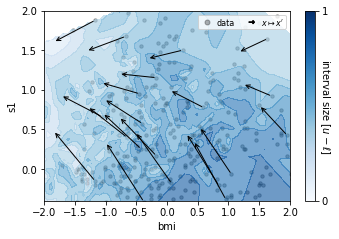

In [15]:
SAVE_FIG = False
fname = 'diabetes_mask_nonlin_uncert'


from scipy.interpolate import griddata
from scipy.ndimage.filters import gaussian_filter
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

feats = [2,4]
m_idx = -1

model = models[m_idx]
w_f = model.f.model.linear.weight.detach().numpy().squeeze()


ngridx = 100
ngridy = 100
x1i = np.linspace(-3, 3.5, ngridx)
x2i = np.linspace(-2.2, 2.2, ngridy)

xp = model.move_points(x,eta,mask)
xp_trn, xp_tst = xp[idx_trn,:], xp[idx_tst,:]
xp1 = xp[:,feats[0]]
xp2 = xp[:,feats[1]]
lb, ub = model.u.predict(xp)
sz = ub-lb

szi = griddata((xp1, xp2), sz, (x1i[None,:], x2i[:,None]), method='linear')

show_idx = [0,70,91,61,83,104,2,46,44,45,106,12,75,11,101,109,80,103,98,51,27,20] #list(range(20))


plt.rcParams['figure.figsize'] = (5.5, 3.5)
plt.scatter(x[:,feats[0]], x[:,feats[1]], color='k', s=12, alpha=0.3) #,markerfacecolor=None)
plt.contourf(x1i, x2i, szi, levels=10, alpha=0.6, cmap='Blues') #, linewidths=0.5, colors='k')
for i in show_idx:
    plt.annotate(s='',xytext=(x_tst[i,feats[0]],x_tst[i,feats[1]]),
                 xy=(xp_tst[i,feats[0]],xp_tst[i,feats[1]]),
                 arrowprops=dict(arrowstyle='->'))

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Blues'))
cbar.set_label('interval size [$u-\ell$]', rotation=270)
cbar.set_ticks([0.,1.0])

plt.xlabel(titles[feats[0]])
plt.ylabel(titles[feats[1]])
plt.axis([-2,2,-0.4,2])

legend_elements = [Line2D([0], [0], marker='o', color='none', label='data',
                          markerfacecolor='k', alpha=0.3, markersize=5),
                  Line2D([0], [0], color='none', marker=r"$\rightarrow$",
                         markerfacecolor='k', label=r"$x \mapsto x'$")]
plt.legend(handles=legend_elements, loc='upper right', ncol=2, fontsize=8,
          columnspacing=1, handletextpad=0.2, borderpad=.2)

if SAVE_FIG:
    plt.draw()
    plt.savefig(fname+'.eps', format='eps', bbox_inches='tight')
    plt.savefig(fname+'.png', format='png', dpi=300, bbox_inches='tight')
    print('saved ' + fname)
else:
    plt.show()

## Plots Lookahead+CQR

<ipython-input-16-a9a8f2e6e7e0>:38: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='',xytext=(x_tst[i,feats[0]],x_tst[i,feats[1]]),


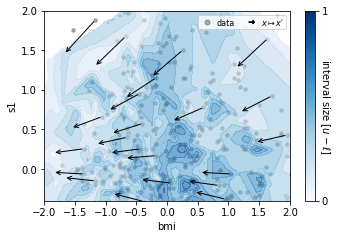

In [16]:
SAVE_FIG = False
fname = 'diabetes_mask_nonlin_uncert_cqr'


from scipy.interpolate import griddata
from scipy.ndimage.filters import gaussian_filter
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

feats = [2,4]
m_idx = -1

model = cqr_models[m_idx]
w_f = model.f.model.linear.weight.detach().numpy().squeeze()


ngridx = 100
ngridy = 100
x1i = np.linspace(-3, 3.5, ngridx)
x2i = np.linspace(-2.2, 2.2, ngridy)

xp = model.move_points(x,eta,mask)
xp_trn, xp_tst = xp[idx_trn,:], xp[idx_tst,:]
xp1 = xp[:,feats[0]]
xp2 = xp[:,feats[1]]
lb, ub = model.u.predict(xp)
sz = ub-lb

szi = griddata((xp1, xp2), sz, (x1i[None,:], x2i[:,None]), method='linear')

show_idx = [0,70,91,61,83,104,2,46,44,45,106,12,75,11,101,109,80,103,98,51,27,20] #list(range(20))


plt.rcParams['figure.figsize'] = (5.5, 3.5)
plt.scatter(x[:,feats[0]], x[:,feats[1]], color='k', s=12, alpha=0.3) #,markerfacecolor=None)
plt.contourf(x1i, x2i, szi, levels=10, alpha=0.6, cmap='Blues') #, linewidths=0.5, colors='k')
for i in show_idx:
    plt.annotate(s='',xytext=(x_tst[i,feats[0]],x_tst[i,feats[1]]),
                 xy=(xp_tst[i,feats[0]],xp_tst[i,feats[1]]),
                 arrowprops=dict(arrowstyle='->'))

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Blues'))
cbar.set_label('interval size [$u-\ell$]', rotation=270)
cbar.set_ticks([0.,1.0])

plt.xlabel(titles[feats[0]])
plt.ylabel(titles[feats[1]])
plt.axis([-2,2,-0.4,2])

legend_elements = [Line2D([0], [0], marker='o', color='none', label='data',
                          markerfacecolor='k', alpha=0.3, markersize=5),
                  Line2D([0], [0], color='none', marker=r"$\rightarrow$",
                         markerfacecolor='k', label=r"$x \mapsto x'$")]
plt.legend(handles=legend_elements, loc='upper right', ncol=2, fontsize=8,
          columnspacing=1, handletextpad=0.2, borderpad=.2)

if SAVE_FIG:
    plt.draw()
    plt.savefig(fname+'.eps', format='eps', bbox_inches='tight')
    plt.savefig(fname+'.png', format='png', dpi=300, bbox_inches='tight')
    print('saved ' + fname)
else:
    plt.show()

<ipython-input-17-96fef670e9c0>:19: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='',xytext=(x_tst[i,feats[0]],x_tst[i,feats[1]]),


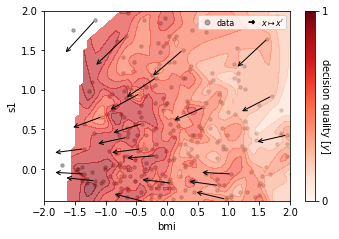

In [17]:
SAVE_FIG = False
fname = 'diabetes_mask_nonlin_y'

x1 = x[:,feats[0]]
x2 = x[:,feats[1]]

yi = griddata((x1, x2), y, (x1i[None,:], x2i[:,None]), method='linear')
yi = gaussian_filter(yi, 0.7)


show_idx = [0,70,91,61,83,104,2,46,44,45,106,12,75,11,101,109,80,103,98,51,27,20] #list(range(20))


plt.rcParams['figure.figsize'] = (5.5, 3.5)
plt.scatter(x[:,feats[0]], x[:,feats[1]], color='k', s=12, alpha=0.3) #,markerfacecolor=None)

plt.contourf(x1i, x2i, yi, levels=10, alpha=0.6, cmap='Reds') #, linewidths=0.5, colors='k')
for i in show_idx:
    plt.annotate(s='',xytext=(x_tst[i,feats[0]],x_tst[i,feats[1]]),
                 xy=(xp_tst[i,feats[0]],xp_tst[i,feats[1]]),
                 arrowprops=dict(arrowstyle='->'))

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Reds'))
cbar.set_label('decision quality [$y$]', rotation=270)
cbar.set_ticks([0.,1.0])
plt.xlabel(titles[feats[0]])
plt.ylabel(titles[feats[1]])
plt.axis([-2,2,-0.4,2])


legend_elements = [Line2D([0], [0], marker='o', color='none', label='data',
                          markerfacecolor='k', alpha=0.3, markersize=5),
                  Line2D([0], [0], color='none', marker=r"$\rightarrow$",
                         markerfacecolor='k', label=r"$x \mapsto x'$")]
plt.legend(handles=legend_elements, loc='upper right', ncol=2, fontsize=8,
          columnspacing=1, handletextpad=0.2, borderpad=.2)


if SAVE_FIG:
    plt.draw()
    plt.savefig(fname+'.eps', format='eps', bbox_inches='tight')
    plt.savefig(fname+'.png', format='png', dpi=300, bbox_inches='tight')
    print('saved ' + fname)
else:
    plt.show()

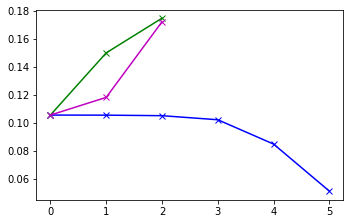

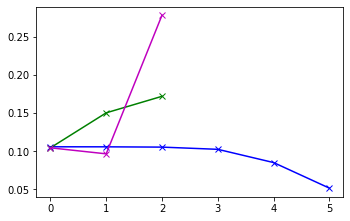

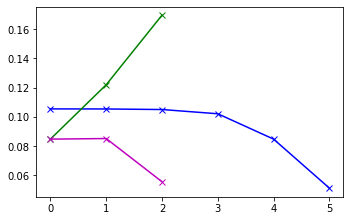

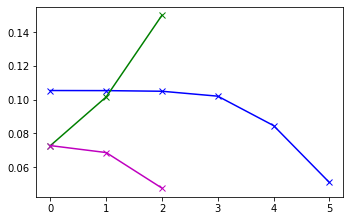

In [18]:
for i in range(len(all_perf_la)):
    plt.figure()
    plt.plot(perf_base['improve'][:,1],'-x', c='b')
    plt.plot(all_perf_la[i]['improve'][:,1],'-x', c='g')
    plt.plot(all_perf_cqr_la[i]['improve'][:,1],'-x', c='m')

seed: 1 , eta: 5.0


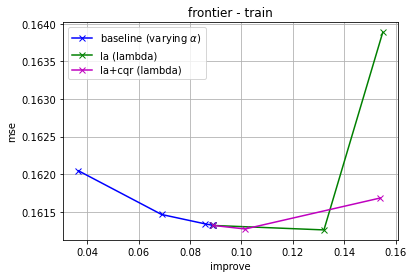

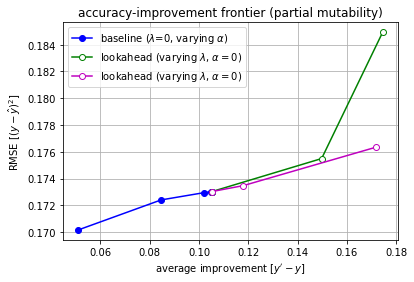

In [19]:
# plot

SAVE_FIG = False
# fname = 'diabetes_mask_nonlin_2-4'

plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', plt.cm.tab20(np.arange(0,22,2)))
alphas_idx = [0] #[0, 4, -2]

print('seed:',seed,', eta:',eta)
plt.plot(perf_base['improve'][:,0], np.sqrt(perf_base['mse'][:,0]),'b-x')
for i in alphas_idx:
    plt.plot(all_perf_la[i]['improve'][:,0], np.sqrt(all_perf_la[i]['mse'][:,0]),'-x', c='g')
    plt.plot(all_perf_cqr_la[i]['improve'][:,0], np.sqrt(all_perf_cqr_la[i]['mse'][:,0]),'-x', c='m')

# plt.plot(perf_naive['improve'][:,0], perf_naive['mse'][:,0],'g-x')
plt.title('frontier - train')
plt.ylabel('mse')
plt.xlabel('improve')
plt.legend([r'baseline (varying $\alpha$)','la (lambda)','la+cqr (lambda)'])
plt.grid()
# plt.ylim([0.,0.18])
plt.show()

plt.plot(perf_base['improve'][:,1], np.sqrt(perf_base['mse'][:,1]),'-o',markerfacecolor=None,c='b')
for i in alphas_idx:
    plt.plot(all_perf_la[i]['improve'][:,1], np.sqrt(all_perf_la[i]['mse'][:,1]),'-o',markerfacecolor='white', c='g')
    plt.plot(all_perf_cqr_la[i]['improve'][:,1], np.sqrt(all_perf_cqr_la[i]['mse'][:,1]),'-o',markerfacecolor='white', c='m')

# plt.plot(perf_naive['improve'][:,1], perf_naive['mse'][:,1],'g-x')
plt.title('accuracy-improvement frontier (partial mutability)')
plt.ylabel('RMSE [$(y-\hat{y})^2$]')
plt.xlabel('average improvement [$y\'-y$]')
plt.legend(
    [
        r'baseline ($\lambda$=0, varying $\alpha$)',
        *[r'lookahead (varying $\lambda$, $\alpha={}$)'.format(alphas_sub[i]) for i in alphas_idx],
        *[r'lookahead (varying $\lambda$, $\alpha={}$)'.format(alphas_sub[i]) for i in alphas_idx]
    ],
    loc='upper left',
)
plt.grid()
# plt.ylim([0.03,0.115])
# plt.xlim([-0.04,0.08])

xx = perf_base['improve'][0,1]
yy =perf_base['mse'][0,1]
plt.annotate(r'$\alpha$',
ha = 'center', va = 'bottom',
xytext = (xx-0.007,yy+0.002),
xy = (xx-0.018, yy-0.002),
arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':0.5, 'headwidth':7, 'headlength':7},
fontsize=11)
plt.annotate(r'$\lambda$',
ha = 'center', va = 'bottom',
xytext = (xx+0.008,yy+0.002),
xy = (xx+0.02, yy-0.001),
arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':0.5, 'headwidth':7, 'headlength':7},
fontsize=11)

plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', plt.cm.tab10(np.arange(10)))

if SAVE_FIG:
    plt.draw()
    plt.savefig(fname+'.eps', format='eps', bbox_inches='tight')
    plt.savefig(fname+'.png', format='png', dpi=300, bbox_inches='tight')
    print('saved ' + fname)
else:
    plt.show()

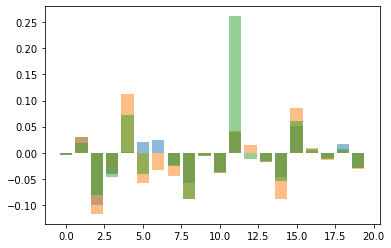

In [20]:
# plt.plot(perf_base['improve'][:,1])
# models[-1].f.model.linear.weight.detach().numpy().squeeze(), models_base[0].f.model.linear.weight.detach().numpy().squeeze(), w_base_skl
plt.bar(np.arange(2*d),cqr_models[-1].f.model.linear.weight.detach().numpy().squeeze(),alpha=0.5)
plt.bar(np.arange(2*d),models[-1].f.model.linear.weight.detach().numpy().squeeze(),alpha=0.5)
plt.bar(np.arange(2*d),models_base[0].f.model.linear.weight.detach().numpy().squeeze(), alpha=0.5)
plt.show()

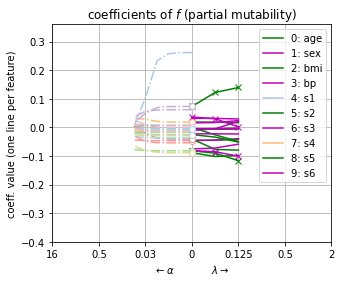

In [21]:
SAVE_FIG = False
# fname = 'wine_mask_ws'


models = all_models[0] #has alpha=0

ws_la_cqr = np.asarray([m.f.model.linear.weight.detach().numpy().squeeze() for m in cqr_models])
ws_la = np.asarray([m.f.model.linear.weight.detach().numpy().squeeze() for m in models])
ws_base = np.asarray([m.f.model.linear.weight.detach().numpy().squeeze() for m in models_base])

mask_idx = np.where(mask>0)[0]
non_mask_idx = np.setdiff1d(np.arange(d), mask_idx)

plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', plt.cm.tab20(np.arange(1,22,2)))
for i in range(d):
    if i not in list(mask_idx):
        plt.plot(np.arange(len(lams)),ws_la[:,i],'-', c='g') #,alpha=a)
        plt.plot(np.arange(len(lams)),ws_la_cqr[:,i],'-', c='m') #,alpha=a)

    else:
        plt.plot([],[])

plt.gca().set_prop_cycle(cycler.cycler('color', plt.cm.tab20(np.arange(0,22,2))))
for i in range(d):
    if i in list(mask_idx):
        plt.plot(np.arange(len(lams)),ws_la[:,i],'-x', c='g') #,alpha=a)
        plt.plot(np.arange(len(lams)),ws_la_cqr[:,i],'-x', c='m') #,alpha=a)
    else:
        plt.plot([],[])

plt.gca().set_prop_cycle(cycler.cycler('color', plt.cm.tab20(np.arange(1,22,2))))
plt.plot(np.arange(0,-len(alphas),-1)/2,ws_base,'-.') #alpha=0.5)

plt.gca().set_prop_cycle(None)
for i in range(len(w_bench)):
    plt.plot(0,ws_base[0,i],'o',markerfacecolor='white')

plt.grid()
plt.ylim([-0.4,0.36])
plt.xlim([-6,6])
plt.title('coefficients of $f$ (partial mutability)')
plt.ylabel('coeff. value (one line per feature)')
plt.xlabel(r'$\leftarrow \alpha \qquad \qquad \lambda \rightarrow$')
plt.xticks([-6,-4,-2,0,2,4,6], [16,0.5,0.03,0,0.125,0.5,2])

custom_lines = [Line2D([0], [0], ls='-', marker='x', color='k', lw=1),
                Line2D([0], [0], ls='-', color='k', lw=1),
                Line2D([0], [0], ls='-.', color='k', lw=1)]
plt.legend(custom_lines, ['lookahead (mutable)', 'lookahead (immutable)', 'baseline'],
          loc='upper left', fontsize=9.5)
plt.legend(titles_idx)

if SAVE_FIG:
    plt.draw()
    plt.savefig(fname+'.eps', format='eps', bbox_inches='tight')
    plt.savefig(fname+'.png', format='png', dpi=300, bbox_inches='tight')
    print('saved ' + fname)
else:
    plt.show()